# Data Cleaning

## Data Dictionary

The raw data contains the following data per station per reading:

* Id - String - API Resource Id
* Name - String - The common name of the station
* PlaceType - String ?
* TerminalName - String - ?
* NbBikes - Integer - The number of available bikes
* NbDocks - Integer - The total number of docking spaces
* NbEmptyDocks - Integer - The number of available empty docking spaces
* Timestamp - DateTime - The moment this reading was captured
* InstallDate - DateTime - Date when the station was installed
* RemovalDate - DateTime - Date when the station was removed
* Installed - Boolean - If the station is installed or not
* Locked - Boolean - ?
* Temporary - Boolean - If the station is temporary or not (TfL adds temporary stations to cope with demand.)
* Latitude - Float - Latitude Coordinate
* Longitude - Float - Longitude Coordinate

The following variables will be derived from the raw data.

* NbUnusableDocks - Integer - The number of non-working docking spaces. Computed with NbUnusableDocks = NbDocks - (NbBikes + NbEmptyDocks)

## Set up

### Imports

In [375]:
%matplotlib inline

import logging
import itertools
import json
import os
import re
import pickle
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from datetime import datetime
from os import listdir
from os.path import isfile, join
from src.data.parse_dataset import parse_dir, parse_json_files, get_file_list
from IPython.display import Image
from datetime import date

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Parse Raw Data 

### Define the Parsing Functions

In [376]:
def parse_cycles(json_obj):
    """Parses TfL's BikePoint JSON response"""

    return [parse_station(element) for element in json_obj]

def parse_station(element):
    """Parses a JSON bicycle station object to a dictionary"""

    obj = {
        'Id': element['id'],
        'Name': element['commonName'],
        'Latitude': element['lat'],
        'Longitude': element['lon'],
        'PlaceType': element['placeType'],
    }

    for p in element['additionalProperties']:
        obj[p['key']] = p['value']

        if 'timestamp' not in obj:
            obj['Timestamp'] = p['modified']
        elif obj['Timestamp'] != p['modified']:
            raise ValueError('The properties\' timestamps for station %s do not match: %s != %s' % (
            obj['id'], obj['Timestamp'], p['modified']))

    return obj

In [377]:
def bike_file_date_fn(file_name):
    """Gets the file's date"""

    return datetime.strptime(os.path.basename(file_name), 'BIKE-%Y-%m-%d:%H:%M:%S.json')

def create_between_dates_filter(file_date_fn, date_start, date_end):
    def filter_fn(file_name):
        file_date = file_date_fn(file_name)
        return file_date >= date_start and file_date <= date_end
    
    return filter_fn

### Quick Data View

#### Load Single Day Data

In [378]:
filter_fn = create_between_dates_filter(bike_file_date_fn, 
                                       datetime(2016, 5, 16, 7, 0, 0),
                                       datetime(2016, 5, 16, 23, 59, 59))

records = parse_dir('/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/cycles', 
                    parse_cycles, sort_fn=bike_file_date_fn, filter_fn=filter_fn)

# records is a list of lists of dicts
df = pd.DataFrame(list(itertools.chain.from_iterable(records))) 

####  All Station View

In [379]:
df.head()

,Id,InstallDate,Installed,Latitude,Locked,Longitude,Name,NbBikes,NbDocks,NbEmptyDocks,PlaceType,RemovalDate,Temporary,TerminalName,Timestamp
0,BikePoints_1,1278947280000,true,51.529163,false,-0.109970,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
1,BikePoints_2,1278585780000,true,51.499606,false,-0.197574,"Phillimore Gardens, Kensington",12,37,25,BikePoint,,false,001018,2016-05-16T06:26:24.037
2,BikePoints_3,1278240360000,true,51.521283,false,-0.084605,"Christopher Street, Liverpool Street",6,32,26,BikePoint,,false,001012,2016-05-16T06:51:27.5
3,BikePoints_4,1278241080000,true,51.530059,false,-0.120973,"St. Chad's Street, King's Cross",14,23,9,BikePoint,,false,001013,2016-05-16T06:51:27.5
4,BikePoints_5,1278241440000,true,51.493130,false,-0.156876,"Sedding Street, Sloane Square",27,27,0,BikePoint,,false,003420,2016-05-16T06:46:27.237


####  Single Station View

In [380]:
df[df['Id'] == 'BikePoints_1'].head()

,Id,InstallDate,Installed,Latitude,Locked,Longitude,Name,NbBikes,NbDocks,NbEmptyDocks,PlaceType,RemovalDate,Temporary,TerminalName,Timestamp
0,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
762,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
1524,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",10,19,8,BikePoint,,false,001023,2016-05-16T07:01:29.163
2286,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",8,19,10,BikePoint,,false,001023,2016-05-16T07:11:30.433
3048,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",8,19,10,BikePoint,,false,001023,2016-05-16T07:11:30.433


#### Observations

* There are some duplicate rows <- remove duplicates
* RemovalDate may contain a lot of nulls <- remove if not helpful
* Locked and Installed might be constant <- remove if not helpful

### Build Dataset

#### Work with Chunks

Due to memory constraints we'll parse the data in chunks. In each chunk we'll remove the redundant candidate keys and also duplicate rows.

In [381]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

#### Tables

We will have two different tables, one for the stations and one for the availability readings

In [382]:
def split_data(parsed_data):
    master_df = pd.DataFrame(list(itertools.chain.from_iterable(parsed_data)))
    
    readings_df = pd.DataFrame(master_df, columns=['Id', 'Timestamp', 'NbBikes', 'NbDocks', 'NbEmptyDocks'])
    stations_df = pd.DataFrame(master_df, columns=['Id', 'Name', 'TerminalName' , 'PlaceType', 'Latitude', 
                                                   'Longitude', 'Installed', 'Temporary', 'Locked',
                                                   'RemovalDate', 'InstallDate'])
    
    return (readings_df, stations_df)

#### Build the Dataset

In [383]:
# get the files to parse
five_weekdays_filter = create_between_dates_filter(bike_file_date_fn, 
                                                   datetime(2016, 5, 15, 11, 0, 0), 
                                                   datetime(2016, 6, 11, 23, 59, 59))

files = get_file_list('data/raw/cycles', filter_fn=None, sort_fn=bike_file_date_fn)

# process the files in chunks
files_batches = chunker(files, 500)

In [384]:
# start with an empty dataset
readings_dataset = pd.DataFrame()
stations_dataset = pd.DataFrame()

# append each chunk to the datasets while removing duplicates
for batch in files_batches:
    parsed_data = parse_json_files(batch, parse_cycles)
    
    # split the data into two station data and readings data
    readings_df, stations_df = split_data(parsed_data)
    
    # append the datasets
    readings_dataset = pd.concat([readings_dataset, readings_df])
    stations_dataset = pd.concat([stations_dataset, stations_df])
    
    # remove duplicated rows
    readings_dataset.drop_duplicates(inplace=True)
    stations_dataset.drop_duplicates(inplace=True)

In [385]:
# put the parsed data in pickle files
pickle.dump(readings_dataset, open("data/parsed/readings_dataset_raw.p", "wb"))
pickle.dump(stations_dataset, open("data/parsed/stations_dataset_raw.p", "wb"))

## Read the Parsed Data

In [386]:
stations_dataset = pickle.load(open('data/parsed/stations_dataset_raw.p', 'rb'))
readings_dataset = pickle.load(open('data/parsed/readings_dataset_raw.p', 'rb'))

## Technically Correct Data

The data is set to be technically correct if it:

1. can be directly recognized as belonging to a certain variable
2. is stored in a data type that represents the value domain of the real-world variable.

In [387]:
# convert columns to their appropriate datatypes
stations_dataset['InstallDate'] = pd.to_numeric(stations_dataset['InstallDate'], errors='raise')
stations_dataset['RemovalDate'] = pd.to_numeric(stations_dataset['RemovalDate'], errors='raise')

stations_dataset['Installed'].replace({'true': True, 'false': False}, inplace=True)
stations_dataset['Temporary'].replace({'true': True, 'false': False}, inplace=True)
stations_dataset['Locked'].replace({'true': True, 'false': False}, inplace=True)

readings_dataset['NbBikes'] = readings_dataset['NbBikes'].astype('uint16')
readings_dataset['NbDocks'] = readings_dataset['NbDocks'].astype('uint16')
readings_dataset['NbEmptyDocks'] = readings_dataset['NbEmptyDocks'].astype('uint16')

In [388]:
# convert string timestamp to datetime
stations_dataset['InstallDate'] = pd.to_datetime(stations_dataset['InstallDate'], unit='ms', errors='raise')
stations_dataset['RemovalDate'] = pd.to_datetime(stations_dataset['RemovalDate'], unit='ms', errors='raise')

readings_dataset['Timestamp'] =  pd.to_datetime(readings_dataset['Timestamp'], format='%Y-%m-%dT%H:%M:%S.%f', errors='raise')

In [389]:
# sort the datasets
stations_dataset.sort_values(by=['Id'], ascending=True, inplace=True)

readings_dataset.sort_values(by=['Timestamp'], ascending=True, inplace=True)

## Derive Data

In [390]:
stations_dataset['ShortName'] = stations_dataset['Name'].apply(lambda x: re.sub('\d*$', '', x.split(',')[0].strip()).strip())

readings_dataset['NbUnusableDocks'] = readings_dataset['NbDocks'] - (readings_dataset['NbBikes'] + readings_dataset['NbEmptyDocks'])

### Add Station Priority Column
Priorities downloaded from https://www.whatdotheyknow.com/request/tfl_boris_bike_statistics?unfold=1

In [391]:
stations_priorities = pd.read_csv('data/priorities/station_priorities.csv', encoding='latin-1')
stations_priorities['Site'] = stations_priorities['Site'].apply(lambda x: x.strip())

In [392]:
stations_dataset = pd.merge(stations_dataset, stations_priorities, how='left', left_on='ShortName', right_on='Site')
stations_dataset['Priority'].replace({'One': 1, 'Two': 2}, inplace=True)
stations_dataset.drop(['Site'], axis=1, inplace=True)
stations_dataset.drop(['Borough'], axis=1, inplace=True)

## Consistent Data

### Stations Analysis

#### Overview

In [393]:
stations_dataset.shape

(784, 13)

In [394]:
stations_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 783
Data columns (total 13 columns):
Id              784 non-null object
Name            784 non-null object
TerminalName    784 non-null object
PlaceType       784 non-null object
Latitude        784 non-null float64
Longitude       784 non-null float64
Installed       784 non-null bool
Temporary       784 non-null bool
Locked          784 non-null bool
RemovalDate     3 non-null datetime64[ns]
InstallDate     688 non-null datetime64[ns]
ShortName       784 non-null object
Priority        742 non-null object
dtypes: bool(3), datetime64[ns](2), float64(2), object(6)
memory usage: 505.3 KB


In [395]:
stations_dataset.head()

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
0,BikePoints_1,"River Street , Clerkenwell",001023,BikePoint,51.529163,-0.109970,True,False,False,NaT,2010-07-12 15:08:00,River Street,2
1,BikePoints_10,"Park Street, Bankside",001024,BikePoint,51.505974,-0.092754,True,False,False,NaT,2010-07-04 11:21:00,Park Street,2
2,BikePoints_100,"Albert Embankment, Vauxhall",001059,BikePoint,51.490435,-0.122806,True,False,False,NaT,2010-07-14 09:31:00,Albert Embankment,2
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1
4,BikePoints_102,"Jewry Street, Aldgate",001045,BikePoint,51.513406,-0.076793,True,False,False,NaT,2010-07-14 10:21:00,Jewry Street,2


In [396]:
stations_dataset.describe()

,Latitude,Longitude
count,784.000000,784.000000
mean,51.440172,-0.128614
std,1.839604,0.056292
min,0.000000,-0.236769
25%,51.493142,-0.172804
50%,51.509191,-0.132007
75%,51.520867,-0.092881
max,51.549369,0.122299


In [397]:
stations_dataset.apply(lambda x:x.nunique())

Id              776
Name            778
TerminalName    776
PlaceType         1
Latitude        774
Longitude       774
Installed         2
Temporary         1
Locked            2
RemovalDate       3
InstallDate     684
ShortName       766
Priority          4
dtype: int64

In [398]:
stations_dataset.isnull().sum()

Id                0
Name              0
TerminalName      0
PlaceType         0
Latitude          0
Longitude         0
Installed         0
Temporary         0
Locked            0
RemovalDate     781
InstallDate      96
ShortName         0
Priority         42
dtype: int64

#### Observations:
* Id, Name and Terminal name seem to be candidate keys
* The minimum latitude and the maximum longitude are 0
* Some stations have the same latitude or longitude
* Id, TerminalName and Name have different unique values
* Placetype, Installed, Temporary and Locked appear to be constant
* Some stations do not have an install date
* Some Stations have a removal date (very sparse)

#### Remove Duplicate Stations

In [399]:
def find_duplicate_ids(df):
    """Find Ids that have more than one value in the given columns"""
    
    df = df.drop_duplicates()
    value_counts_grouped_by_id = df.groupby('Id').count()    
    is_duplicate_id = value_counts_grouped_by_id.applymap(lambda x: x > 1).any(axis=1)
    duplicate_ids = value_counts_grouped_by_id[is_duplicate_id == True].index.values
    return df[df['Id'].isin(duplicate_ids)]

diplicate_ids = find_duplicate_ids(stations_dataset)
diplicate_ids

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
415,BikePoints_497,"Merchant Street, Bow",200242,BikePoint,51.526177,-0.027467,True,False,False,NaT,2012-01-24 09:47:00,Merchant Street,NaN
416,BikePoints_497,"Merchant Street, Bow",200242,BikePoint,51.526535,-0.028619,True,False,False,NaT,2012-01-24 09:47:00,Merchant Street,NaN
724,BikePoints_780,"Imperial Wharf Station, Sands End",300070,BikePoint,51.474665,-0.183165,True,False,False,NaT,2015-08-13 08:40:00,Imperial Wharf Station,2
725,BikePoints_780,Imperial Wharf Station,300070,BikePoint,51.474665,-0.183165,True,False,False,NaT,2015-08-13 08:40:00,Imperial Wharf Station,2
741,BikePoints_796,"Coram Street, Bloomsbury",300201,BikePoint,51.524000,-0.126409,True,False,False,NaT,2016-02-29 11:47:00,Coram Street,NaN
742,BikePoints_796,"Coram Street, Bloomsbury",300201,BikePoint,51.524000,-0.126409,True,False,True,NaT,2016-02-29 11:47:00,Coram Street,NaN
743,BikePoints_798,"Birkenhead Street, King's Cross",300212,BikePoint,51.530199,-0.122299,True,False,False,NaT,NaT,Birkenhead Street,NaN
744,BikePoints_798,"Birkenhead Street, King's Cross",300212,BikePoint,51.530199,0.122299,True,False,False,NaT,NaT,Birkenhead Street,NaN
745,BikePoints_799,"Kings Gate House, Westminster",300202,BikePoint,51.497698,-0.137598,True,False,False,NaT,NaT,Kings Gate House,NaN
746,BikePoints_799,"Kings Gate House, Westminster",300202,BikePoint,51.497698,-0.137598,True,False,False,NaT,2016-06-02 14:08:00,Kings Gate House,NaN


Given these records have the same location and Id but different Name or TerminalName, we'll assume the station changed name and remove the first entries.

In [400]:
# remove the one not in merchant street
stations_dataset.drop(416, inplace=True)

# remove the one with the shortest name
stations_dataset.drop(725, inplace=True)

# remve the one that is not in kings cross (as the name of the station implies)
stations_dataset.drop(744, inplace=True)

# remove the duplicated entries 
stations_dataset.drop([741, 745, 752, 760, 763],  inplace=True)

In [401]:
# make sure there are no repeated ids 
assert len(find_duplicate_ids(stations_dataset)) == 0

#### Check Locations

Let's have a closer look at the station locations. All of them should be in Greater London.

In [402]:
# bounding box for Greater London
min_longitude = -0.489
min_latitude = 51.28
max_longitude = 0.236
max_latitude = 51.686

def find_locations_outside_box(locations, min_longitude, min_latitude, max_longitude, max_latitude):
    latitude_check = ~(locations['Latitude'] >= min_latitude) & (locations['Latitude'] <= max_latitude) 
    longitude_check = ~(locations['Longitude'] >= min_longitude) & (locations['Longitude'] <= max_longitude) 
    return locations[(latitude_check | longitude_check)]

outlier_locations_df = find_locations_outside_box(stations_dataset, min_longitude, min_latitude, max_longitude, max_latitude)
outlier_locations_df

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
736,BikePoints_791,Test Desktop,666666,BikePoint,0.0,0.0,False,False,False,NaT,2016-01-15 12:39:00,Test Desktop,NaN


This station looks like a test dation, so we'll remove it.

In [403]:
outlier_locations_idx = outlier_locations_df.index.values

stations_dataset.drop(outlier_locations_idx, inplace=True)

In [404]:
# make sure there are no stations outside London
assert len(find_locations_outside_box(stations_dataset, min_longitude, min_latitude, max_longitude, max_latitude)) == 0

We will investigate the fact that there are stations with duplicate latitude or longitude values.

In [405]:
# find stations with duplicate longitude
id_counts_groupedby_longitude = stations_dataset.groupby('Longitude')['Id'].count()
nonunique_longitudes = id_counts_groupedby_longitude[id_counts_groupedby_longitude != 1].index.values
nonunique_longitude_stations = stations_dataset[stations_dataset['Longitude'].isin(nonunique_longitudes)].sort_values(by=['Longitude'])

id_counts_groupedby_latitude = stations_dataset.groupby('Latitude')['Id'].count()
nonunique_latitudes = id_counts_groupedby_latitude[id_counts_groupedby_latitude != 1].index.values
nonunique_latitudes_stations = stations_dataset[stations_dataset['Latitude'].isin(nonunique_latitudes)].sort_values(by=['Latitude'])

nonunique_coordinates_stations = pd.concat([nonunique_longitude_stations, nonunique_latitudes_stations])
nonunique_coordinates_stations

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
127,BikePoints_216,"Old Brompton Road, South Kensington",003479,BikePoint,51.490945,-0.181190,True,False,False,NaT,2010-07-19 11:12:00,Old Brompton Road,2
498,BikePoints_573,"Limerston Street, West Chelsea",200001,BikePoint,51.485587,-0.181190,True,False,False,NaT,2012-03-15 07:21:00,Limerston Street,2
120,BikePoints_21,"Hampstead Road (Cartmel), Euston",003426,BikePoint,51.530078,-0.138846,True,False,False,NaT,2010-07-06 14:49:00,Hampstead Road (Cartmel),2
235,BikePoints_318,"Sackville Street, Mayfair",001197,BikePoint,51.510048,-0.138846,True,False,False,NaT,2010-07-23 11:42:00,Sackville Street,2
10,BikePoints_108,"Abbey Orchard Street, Westminster",003429,BikePoint,51.498125,-0.132102,True,False,False,NaT,2010-07-14 11:42:00,Abbey Orchard Street,1
552,BikePoints_624,"Courland Grove, Wandsworth Road",200173,BikePoint,51.472918,-0.132102,True,False,False,NaT,2013-10-08 09:24:00,Courland Grove,2
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1
343,BikePoints_427,"Cheapside, Bank",022180,BikePoint,51.513970,-0.092940,True,False,False,NaT,2011-07-15 10:28:00,Cheapside,1
10,BikePoints_108,"Abbey Orchard Street, Westminster",003429,BikePoint,51.498125,-0.132102,True,False,False,NaT,2010-07-14 11:42:00,Abbey Orchard Street,1
391,BikePoints_474,"Castalia Square, Cubitt Town",200155,BikePoint,51.498125,-0.011457,True,False,False,NaT,2012-01-17 17:56:00,Castalia Square,2


In [406]:
def draw_stations_map(stations_df):
    london_longitude = -0.127722
    london_latitude = 51.507981
    
    stations_map = folium.Map(location=[london_latitude, london_longitude], zoom_start=12,
                      min_lat=min_latitude, max_lat=max_latitude,
                      min_lon=min_longitude, max_lon=max_longitude)

    for index, station in stations_df.iterrows():
        folium.Marker([station['Latitude'],station['Longitude']], popup=station['Name']).add_to(stations_map)
    
    return stations_map

In [407]:
draw_stations_map(nonunique_coordinates_stations)

We can observe that the stations are different and that having the same Longitude is just a coincidence.

Let's plot all the stations in a map to see how it looks

In [408]:
london_longitude = -0.127722
london_latitude = 51.507981

MAX_RECORDS = 100

stations_map = folium.Map(location=[london_latitude, london_longitude], zoom_start=12,
                  min_lat=min_latitude, max_lat=max_latitude,
                  min_lon=min_longitude, max_lon=max_longitude)

for index, station in stations_dataset[0:MAX_RECORDS].iterrows():
    folium.Marker([station['Latitude'],station['Longitude']], popup=station['Name']).add_to(stations_map)
    
stations_map

#folium.Map.save(stations_map, 'reports/maps/stations_map.html')

### Readings Analysis

#### Overview

In [409]:
readings_dataset.shape

(1302908, 6)

In [410]:
readings_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302908 entries, 750 to 82044
Data columns (total 6 columns):
Id                 1302908 non-null object
Timestamp          1302908 non-null datetime64[ns]
NbBikes            1302908 non-null uint16
NbDocks            1302908 non-null uint16
NbEmptyDocks       1302908 non-null uint16
NbUnusableDocks    1302908 non-null uint16
dtypes: datetime64[ns](1), object(1), uint16(4)
memory usage: 173.2 MB


In [411]:
readings_dataset.head()

,Id,Timestamp,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
750,BikePoints_791,2016-05-10 15:34:07.137,0,0,0,0
608,BikePoints_646,2016-05-14 20:36:22.417,0,0,0,0
570,BikePoints_608,2016-05-14 23:18:18.467,14,29,15,0
666,BikePoints_704,2016-05-15 00:50:38.140,9,18,9,0
634,BikePoints_672,2016-05-15 04:11:04.447,28,28,0,0


In [412]:
readings_dataset.describe()

,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
count,1.302908e+06,1.302908e+06,1.302908e+06,1.302908e+06
mean,1.243546e+01,2.701451e+01,1.400107e+01,5.779794e-01
std,9.103660e+00,9.519458e+00,9.582803e+00,9.114281e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,2.000000e+01,7.000000e+00,0.000000e+00
50%,1.100000e+01,2.500000e+01,1.300000e+01,0.000000e+00
75%,1.800000e+01,3.300000e+01,1.900000e+01,1.000000e+00
max,6.100000e+01,6.400000e+01,6.400000e+01,3.800000e+01


In [413]:
readings_dataset.apply(lambda x:x.nunique())

Id                   776
Timestamp          11386
NbBikes               62
NbDocks               58
NbEmptyDocks          65
NbUnusableDocks       20
dtype: int64

In [414]:
readings_dataset.isnull().sum()

Id                 0
Timestamp          0
NbBikes            0
NbDocks            0
NbEmptyDocks       0
NbUnusableDocks    0
dtype: int64

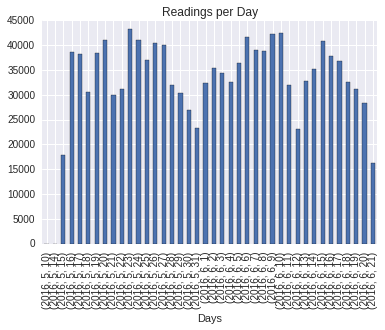

In [415]:
timestamps = readings_dataset['Timestamp']
ax = timestamps.groupby([timestamps.dt.year, timestamps.dt.month, timestamps.dt.day]).count().plot(kind="bar")
ax.set_xlabel('Days')
ax.set_title('Readings per Day')

#### Observations:
* The number of readings in each day varies widely

#### Discard Out of Range Data
We will only keep data between 16/05/2016 and 12/6/2016, which is 4 weeks of data.

In [416]:
start_date = date(2016, 5, 16)
end_date = date(2016, 6, 20)
days = set(pd.date_range(start=start_date, end=end_date, closed='left'))
           
readings_dataset = readings_dataset[(timestamps > start_date) & (timestamps < end_date)]

#### Readings Consistency Through Days
Lets get some insight about which stations do not have readings during an entire day

In [417]:
# get a subview of the readings dataset
id_timestamp_view = readings_dataset.loc[:,['Id','Timestamp']]

# remove the time component of the timestamp
id_timestamp_view['Timestamp'] = id_timestamp_view['Timestamp'].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# compute the days of readings per stations
days_readings = id_timestamp_view.groupby('Id').aggregate(lambda x: set(x))
days_readings['MissingDays'] = days_readings['Timestamp'].apply(lambda x: list(days - x))
days_readings['MissingDaysCount'] = days_readings['MissingDays'].apply(lambda x: len(x))

In [418]:
def expand_datetime(df, datetime_col):
    df['Weekday'] = df[datetime_col].apply(lambda x: x.weekday())
    return df

In [419]:
# get the stations with missing readings only
missing_days_readings = days_readings[days_readings['MissingDaysCount'] != 0]
missing_days_readings = missing_days_readings['MissingDays'].apply(lambda x: pd.Series(x)).unstack().dropna()
missing_days_readings.index = missing_days_readings.index.droplevel()

# sort and format in their own DF
missing_days_readings = pd.DataFrame(missing_days_readings, columns=['MissingDay'], index=None).reset_index().sort_values(by=['Id', 'MissingDay'])

# expand the missing day date
expand_datetime(missing_days_readings, 'MissingDay')

,Id,MissingDay,Weekday
0,BikePoints_112,2016-05-25,2
37,BikePoints_112,2016-05-26,3
38,BikePoints_120,2016-06-10,4
1,BikePoints_120,2016-06-11,5
2,BikePoints_153,2016-06-17,4
65,BikePoints_153,2016-06-18,5
39,BikePoints_153,2016-06-19,6
3,BikePoints_218,2016-06-04,5
4,BikePoints_226,2016-05-16,0
40,BikePoints_277,2016-06-16,3


In [420]:
missing_days_readings['Id'].nunique()

37

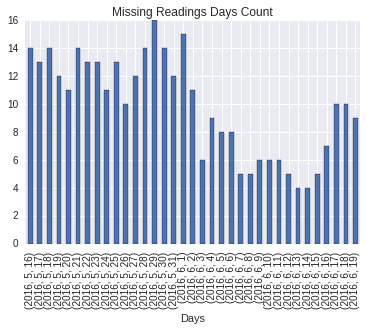

In [421]:
# plot the missing readings days 
days = missing_days_readings['MissingDay']
missing_days_counts = days.groupby([days.dt.year, days.dt.month, days.dt.day]).count()
ax = missing_days_counts.plot(kind="bar")
ax.set_xlabel('Days')
ax.set_title('Missing Readings Days Count')

Stations with no readings in at least one day

In [422]:
missing_days_readings_stations = stations_dataset[stations_dataset['Id'].isin(missing_days_readings['Id'].unique())]
draw_stations_map(missing_days_readings_stations)

Stations with no readings in at least one day during the weekend

In [423]:
weekend_readings = missing_days_readings[missing_days_readings['Weekday'] > 4]
missing_dayreadings_stn = stations_dataset[stations_dataset['Id'].isin(weekend_readings['Id'].unique())]
draw_stations_map(missing_dayreadings_stn)

Stations with no readings in at least one day during weekdays

In [424]:
weekday_readings = missing_days_readings[missing_days_readings['Weekday'] < 5]
missing_dayreadings_stn = stations_dataset[stations_dataset['Id'].isin(weekday_readings['Id'].unique())]
draw_stations_map(missing_dayreadings_stn)

Observations:
* There are 29 stations that do not have readings in at least one day
* There were more stations without readings during May than in June
* Other than that, there is no visible pattern

#### Discard Non Relevant Data

In [425]:
hour = readings_dataset['Timestamp'].apply(lambda x: x.hour)
selector = (hour < 7) | (hour > 22)
readings_dataset.drop(readings_dataset[selector].index, inplace=True)

## Build Datasets
### Readings

In [426]:
readings_dataset.reset_index(inplace=True, drop=True)

In [427]:
readings_dataset.head()

,Id,Timestamp,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
0,BikePoints_292,2016-05-16 07:01:29.163,9,16,7,0
1,BikePoints_594,2016-05-16 07:01:29.163,7,33,26,0
2,BikePoints_244,2016-05-16 07:01:29.163,12,18,6,0
3,BikePoints_592,2016-05-16 07:01:29.163,10,20,10,0
4,BikePoints_586,2016-05-16 07:01:29.163,28,31,1,2


In [428]:
readings_dataset.describe()

,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
count,739335.000000,739335.000000,739335.000000,739335.000000
mean,12.405612,26.949019,13.961618,0.581789
std,9.062923,9.504919,9.464680,0.918312
min,0.000000,0.000000,0.000000,0.000000
25%,5.000000,20.000000,7.000000,0.000000
50%,11.000000,25.000000,13.000000,0.000000
75%,18.000000,33.000000,19.000000,1.000000
max,61.000000,64.000000,64.000000,38.000000


In [429]:
readings_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739335 entries, 0 to 739334
Data columns (total 6 columns):
Id                 739335 non-null object
Timestamp          739335 non-null datetime64[ns]
NbBikes            739335 non-null uint16
NbDocks            739335 non-null uint16
NbEmptyDocks       739335 non-null uint16
NbUnusableDocks    739335 non-null uint16
dtypes: datetime64[ns](1), object(1), uint16(4)
memory usage: 92.6 MB


In [430]:
pickle.dump(readings_dataset, open("data/parsed/readings_dataset_final.p", "wb"))

### Stations

In [431]:
stations_dataset.reset_index(inplace=True, drop=True)

In [432]:
stations_dataset.head()

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate,ShortName,Priority
0,BikePoints_1,"River Street , Clerkenwell",001023,BikePoint,51.529163,-0.109970,True,False,False,NaT,2010-07-12 15:08:00,River Street,2
1,BikePoints_10,"Park Street, Bankside",001024,BikePoint,51.505974,-0.092754,True,False,False,NaT,2010-07-04 11:21:00,Park Street,2
2,BikePoints_100,"Albert Embankment, Vauxhall",001059,BikePoint,51.490435,-0.122806,True,False,False,NaT,2010-07-14 09:31:00,Albert Embankment,2
3,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,False,False,NaT,2010-07-14 10:18:00,Queen Street,1
4,BikePoints_102,"Jewry Street, Aldgate",001045,BikePoint,51.513406,-0.076793,True,False,False,NaT,2010-07-14 10:21:00,Jewry Street,2


In [433]:
stations_dataset.describe()

,Latitude,Longitude
count,775.000000,775.000000
mean,51.505924,-0.129238
std,0.020009,0.055518
min,51.454752,-0.236769
25%,51.493194,-0.173343
50%,51.509230,-0.132102
75%,51.520849,-0.092940
max,51.549369,-0.002275


In [434]:
stations_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 13 columns):
Id              775 non-null object
Name            775 non-null object
TerminalName    775 non-null object
PlaceType       775 non-null object
Latitude        775 non-null float64
Longitude       775 non-null float64
Installed       775 non-null bool
Temporary       775 non-null bool
Locked          775 non-null bool
RemovalDate     3 non-null datetime64[ns]
InstallDate     684 non-null datetime64[ns]
ShortName       775 non-null object
Priority        741 non-null object
dtypes: bool(3), datetime64[ns](2), float64(2), object(6)
memory usage: 493.6 KB


In [435]:
pickle.dump(stations_dataset, open("data/parsed/stations_dataset_final.p", "wb"))